# Grid Study and Sensitivity Analysis

In [1]:
import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import concurrent.futures as cf
import itertools as it
from sympy import divisors
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.interpolate import interp1d

In [2]:
remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()

In [3]:
def exp_fun(x, c, a):
    return c*np.exp(-a*x)

### Define Constants

In [4]:
from scipy.sparse.linalg import gmres

In [5]:
# Hard-coded parameters
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)

# Light from above
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 200
maxiter_outer = 200
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax,
         tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_wrapper)

# Compare FD & Exact Solution

In [ ]:
# Set parameters
a_water = 0.5
b = 0.00
ns = 10
na = 10
kelp_profile='none'

nz_max = 24
nz_list = np.array(divisors(24))
nz_list = nz_list[nz_list>3]

# Exact solution (no kelp, no scattering)
exact_results = lv.apply(kelp_param.kelp_calculate,
    a_water,
    b,
    ns,
    na,
    nz_max,
    kelp_profile,
    absorptance_kelp=0.8,
    gmres_flag=False,
    num_scatters=0,
    const=const
).result()

exact_irrad = exact_results['irradiance'].mean(axis=(0,1))

irrad_list = []
abs_err_list = []
rel_err_list = []

# Run scattering cases
for nz in nz_list:
    print("nz={}".format(nz))
    #print("const={}".format(const))
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    irrad = compute_results['irradiance'].mean(axis=(0,1))
    irrad_list.append(irrad)
    
    block_exact_irrad = kelp_param.block_mean(exact_irrad, irrad.shape)
    abs_err = np.mean(np.abs(irrad-block_exact_irrad))
    abs_err_list.append(abs_err)
    rel_err = np.mean(np.abs(irrad-block_exact_irrad)/block_exact_irrad)
    rel_err_list.append(rel_err)

In [ ]:
plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/max(nz_list)
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.ylim(1e-2, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Log Average Irradiance')

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    plt.plot(z, irrad, '-o', label='nz={}'.format(nz))
dz = (zmax-zmin)/nz_max
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
plt.plot(z, exact_irrad, '-s', lw=3, label='exact')
plt.yscale('linear')
plt.xlim(zmin, zmax)
plt.ylim(0, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')


plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs(irrad-block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Absolute Error')

plt.figure()
for nz, irrad in zip(nz_list, irrad_list):
    dz = (zmax-zmin)/nz
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    block_exact_irrad = kelp_param.block_mean(exact_irrad, [nz])
    plt.plot(z, np.abs((irrad-block_exact_irrad)/block_exact_irrad), '-o', label='nz={}'.format(nz))
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(nz_list, abs_err_list, 'C0o-', label='abs. err.')
ax1.set_xlabel('nz')
ax1.set_ylabel('avg. abs. irrad. err')
ax1.legend(loc='upper left')
ax2.plot(nz_list, rel_err_list, 'C1o-', label='rel. err.')
ax2.set_ylabel('avg. rel. irrad. err')
ax2.legend(loc='upper right')


plt.show()

# Grid Study

In [100]:
def merge_diff_grid(xmin, xmax, y1, y2):
    """Cast discrete quantities with different spacings to a common grid.
    Piecewise constant interpolation.
    """
    n1 = len(y1)
    n2 = len(y2)
    d1 = (xmax-xmin)/n1
    d2 = (xmax-xmin)/n2
    # Grid centers
    x1 = np.linspace(xmin+d1/2, xmax-d1/2, n1)
    x2 = np.linspace(xmin+d2/2, xmax-d2/2, n2)
    
    # Edges
    e1 = np.linspace(xmin, xmax, n1+1)
    e2 = np.linspace(xmin, xmax, n2+1)

    i_sort = np.argsort(np.concatenate([x1,x2]))
    i1 = i_sort<n1
    i2 = i_sort>=n1

    x3 = np.zeros(n1+n2)
    x3[i1] = x1
    x3[i2] = x2

    z1 = np.zeros_like(x3)
    z2 = np.zeros_like(x3)

    #z1[i1] = y1
    #z2[i2] = y2

    z1[x3<(x1[0]+x1[1])/2]
    for i in range(n1):
        wh = np.logical_and(
            e1[i]<=x3,
            x3<e1[i+1]
        )
        z1[wh] = y1[i]

    for i in range(n2):
        wh = np.logical_and(
            e2[i]<=x3,
            x3<e2[i+1]
        )
        z2[wh] = y2[i]
        
    return x3, z1, z2

def abs_err_uneven(xmin, xmax, y1, y2):
    "Integral of absolute difference between discrete quantities with different spacings."
    x, z1, z2 = merge_diff_grid(xmin, xmax, y1, y2)
    
    return np.sum(np.abs(
        (z1-z2) * np.diff(np.concatenate([x,[xmax]]))
    ))

def rel_err_uneven(xmin, xmax, y1, y2):
    "Integral of absolute difference between discrete quantities with different spacings."
    x, z1, z2 = merge_diff_grid(xmin, xmax, y1, y2)
    
    return np.sum(np.abs(
        (z1-z2)/z1 * np.diff(np.concatenate([x,[xmax]]))
    ))


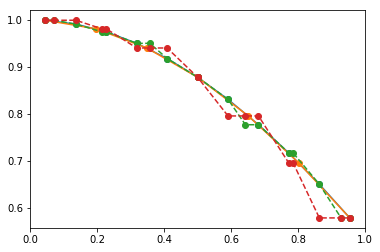

0.0151181461468
[ 0.          0.         -0.00832755 -0.00654796 -0.00654796  0.01043857
  0.01043857 -0.02442374  0.          0.          0.04247007 -0.02413328
 -0.02413328  0.02999925  0.02999925  0.11035881  0.          0.        ]
0.0197322987365


In [94]:
xmin = 0
xmax = 1
n1 = 11
d1 = (xmax-xmin)/n1
n2 = 7
d2= (xmax-xmin)/n2
x1 = np.linspace(xmin+d1/2, xmax-d1/2, n1)
y1 = np.cos(x1)
x2 = np.linspace(xmin+d1/2, xmax-d1/2, n2)
y2 = np.cos(x2)
x3, z1, z2 = merge_diff_grid(xmin, xmax, y1, y2)
plt.plot(x1, y1, 'o-', label='y1')
plt.plot(x2, y2, 'o-', label='y2')
plt.plot(x3, z1, 'o--', label='z1')
plt.plot(x3, z2, 'o--', label='z2')
plt.show()
print(abs_err_uneven(xmin, xmax, y1, y2))
print(rel_err_uneven(xmin, xmax, y1, y2))

In [ ]:
def compute_block_err(ns, nz, na, best_irrad, a_water, b, kelp_profile, absorptance_kelp, const):
    print("ns={}, nz={}, na={}".format(ns,nz,na))
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    irrad = compute_results['irradiance'].mean(axis=(0,1))
    block_best_irrad = kelp_param.block_mean(best_irrad, irrad.shape)
    abs_err = np.mean(np.abs(irrad-block_best_irrad))
    rel_err = np.mean(np.abs((irrad-block_best_irrad)/block_best_irrad))
    return irrad, abs_err, rel_err

def compute_err(ns, nz, na, best_perceived_irrad, a_water, b, kelp_profile, absorptance_kelp, const):
    print("ns={}, nz={}, na={}".format(ns,nz,na))
    
    compute_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    p_kelp = compute_results['p_kelp']
    irrad = compute_results['irradiance']
    # Perceived irradiance for each depth layer
    perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    # If p_kelp is 0, then so is perceied_irrad
    perceived_irrad[np.isnan(perceived_irrad)] = 0
    abs_err = abs_err_uneven(zmin, zmax, best_perceived_irrad, perceived_irrad)
    rel_err = rel_err_uneven(zmin, zmax, best_perceived_irrad, perceived_irrad)
    return perceived_irrad, abs_err, rel_err

In [84]:
def grid_study_compute(a_water, absorptance_kelp, kelp_profile, ns_list, nz_list, na_list):
    ns_max = max(ns_list)
    nz_max = max(nz_list)
    na_max = max(na_list)
    
    print("ns_max = {}".format(ns_max))
    print("nz_max = {}".format(nz_max))
    print("na_max = {}".format(na_max))

    # best solution (no kelp, no scattering)
    best_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns_max,
        na_max,
        nz_max,
        kelp_profile,
        absorptance_kelp,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()
    
    perceived_irrad_dict = {}
    abs_err_arr = np.zeros([len(ns_list),len(nz_list),len(na_list)])
    rel_err_arr = np.zeros([len(ns_list),len(nz_list),len(na_list)])

    p_kelp = best_results['p_kelp']
    best_irrad = best_results['irradiance']
    best_perceived_irrad = np.sum(p_kelp*best_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    perceived_irrad_dict[(ns_max,nz_max,na_max)] = best_perceived_irrad
    
    # Vary nz
    ns = ns_max
    na = na_max
    for i, nz in enumerate(nz_list[:-1]):
        perceived_irrad, abs_err, rel_err = compute_err(ns, nz, na, best_perceived_irrad, a_water, b, kelp_profile, absorptance_kelp, const)
        perceived_irrad_dict[(ns, nz, na)] = perceived_irrad
        abs_err_arr[i, -1, -1] = abs_err
        rel_err_arr[i, -1, -1] = rel_err

    # Vary ns
    nz = nz_max
    na = na_max
    for i, ns in enumerate(ns_list[:-1]):
        perceived_irrad, abs_err, rel_err = compute_err(ns, nz, na, best_perceived_irrad, a_water, b, kelp_profile, absorptance_kelp, const)
        perceived_irrad_dict[(ns, nz, na)] = perceived_irrad
        abs_err_arr[-1, i, -1] = abs_err
        rel_err_arr[-1, i, -1] = rel_err

    # Vary na
    ns = ns_max
    nz = nz_max
    for i, na in enumerate(na_list[:-1]):
        perceived_irrad, abs_err, rel_err = compute_err(ns, nz, na, best_perceived_irrad, a_water, b, kelp_profile, absorptance_kelp, const)
        perceived_irrad_dict[(ns, nz, na)] = perceived_irrad
        abs_err_arr[-1, -1, i] = abs_err
        rel_err_arr[-1, -1, i] = rel_err
        
    return perceived_irrad_dict, abs_err_arr, rel_err_arr

In [71]:
def slice_1d(n_list, best_ind, irrad_dict, pos, label):
    ns_max, nz_max, na_max = best_ind
    n_max = best_ind[pos]
    best_perceived_irrad = irrad_dict[(ns_max,nz_max,na_max)]
    
    dz = (zmax-zmin)/nz_max
    z_best = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz_max)
    
    plt.figure(figsize=[8,6])
    
    # Log Average Irradiance
    ind = best_ind[:]
    plt.subplot(2,2,1)
    for n in n_list[:-1]:
        ind[pos] = n
        nz = ind[1]
        dz = (zmax-zmin)/nz
        z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
        irrad = irrad_dict[tuple(ind)]
        plt.plot(z, irrad, '-o', label='{}={}'.format(label,n))
    plt.plot(z_best, best_perceived_irrad, '-s', lw=3, label='{}={}'.format(label,n_max))
    plt.yscale('log')
    plt.xlim(zmin, zmax)
    #plt.ylim(1e-2, I0)
    #plt.legend()
    plt.xlabel('z (depth)')
    plt.ylabel('Log Average Irradiance')

    # Linear Average Irradiance
    ind = best_ind[:]
    plt.subplot(2,2,2)
    for n in n_list[:-1]:
        ind[pos] = n
        nz = ind[1]
        dz = (zmax-zmin)/nz
        z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
        irrad = irrad_dict[tuple(ind)]
        plt.plot(z, irrad, '-o', label='{}={}'.format(label,n))
    plt.plot(z_best, best_perceived_irrad, '-s', lw=3, label='{}={}'.format(label,n_max))
    plt.yscale('linear')
    plt.xlim(zmin, zmax)
    #plt.ylim(0, I0)
    plt.legend(loc='upper left', bbox_to_anchor=(1.1,1))
    plt.xlabel('z (depth)')
    plt.ylabel('Average Irradiance')

    # Absolute Error vs depth
    ind = best_ind[:]
    plt.subplot(2,2,3)
    for n in n_list[:-1]:
        ind[pos] = n
        nz = ind[1]
        dz = (zmax-zmin)/nz
        z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
        irrad = irrad_dict[tuple(ind)]
        this_interp = interp1d(z, irrad, fill_value='extrapolate')
        best_interp = interp1d(z_best, best_perceived_irrad)
        diff_interp = lambda z: this_interp(z) - best_interp(z)
        z_both = np.sort(np.concatenate([z, z_best]))
        abs_err = np.abs(best_interp(z_both)-this_interp(z_both))
        plt.plot(z_both, abs_err, '-o', label='{}={}'.format(label,n))
    plt.yscale('log')
    plt.xlim(zmin, zmax)
    #plt.legend()
    plt.xlabel('z (depth)')
    plt.ylabel('Absolute Error')

    # Relative Error vs depth
    ind = best_ind[:]
    plt.subplot(2,2,4)
    for n in n_list[:-1]:
        ind[pos] = n
        nz = ind[1]
        dz = (zmax-zmin)/nz
        z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
        irrad = irrad_dict[tuple(ind)]
        this_interp = interp1d(z, irrad, fill_value='extrapolate')
        best_interp = interp1d(z_best, best_perceived_irrad)
        z_both = np.sort(np.concatenate([z, z_best]))
        rel_err = np.abs((best_interp(z_both)-this_interp(z_both))/best_interp(z_both))
        plt.plot(z_both, rel_err, '-o', label='{}={}'.format(label,n))
    plt.yscale('log')
    plt.xlim(zmin, zmax)
    #plt.legend()
    plt.xlabel('z (depth)')
    plt.ylabel('Relative Error')
    
    plt.tight_layout()
    plt.show()


In [58]:
# Plot Convergence Curves
def grid_study_plot(ns_list, nz_list, na_list, irrad_dict, abs_err_arr, rel_err_arr):
    ns_max = max(ns_list)
    nz_max = max(nz_list)
    na_max = max(na_list)
    
    nz = ns_max
    ns = ns_max
    
    best_ind = [ns_max, nz_max, na_max]
    for pos, (label,n_list) in enumerate(zip(['ns','nz','na'],(ns_list,nz_list,na_list))):
        slice_1d(n_list, best_ind, irrad_dict, pos, label)
    
    # Relative error vs resolution
    fig, ax1 = plt.subplots()
    ax1.plot(ns_list[:-1], rel_err_arr[:-1,-1,-1], 'o-', label='ns')
    ax1.plot(nz_list[:-1], rel_err_arr[-1,:-1,-1], 'o-', label='nz')
    ax1.plot(na_list[:-1], rel_err_arr[-1,-1,:-1], 'o-', label='na')
    ax1.set_xlabel('Number of grid points')
    ax1.set_ylabel('Relative Error')
    ax1.set_yscale('log')
    ax1.legend(loc='upper left')
    plt.tight_layout()
    
    plt.show()

# Grid Study 1

In [118]:
# Set parameters
a_water = 0.5
b = 0.05
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 20
nz_max = 20
na_max = 20
ns_list = range(4, ns_max+1, 2)
nz_list = range(4, nz_max+1, 2)
na_list = range(4, na_max+1, 2)

ex = cf.ThreadPoolExecutor()
gs_fut = ex.submit(
    grid_study_compute,
    a_water, absorptance_kelp, kelp_profile, ns_list, nz_list, na_list
)

ns_max = 20
nz_max = 20
na_max = 20
ns=20, nz=4, na=20
ns=20, nz=6, na=20
ns=20, nz=8, na=20
ns=20, nz=10, na=20
ns=20, nz=12, na=20
ns=20, nz=14, na=20
ns=20, nz=16, na=20
ns=20, nz=18, na=20


In [119]:
perceived_irrad_dict, abs_err_arr, rel_err_arr = gs_fut.result()

ns=4, nz=20, na=20


/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


ns=6, nz=20, na=20
ns=8, nz=20, na=20
ns=10, nz=20, na=20
ns=12, nz=20, na=20
ns=14, nz=20, na=20
ns=16, nz=20, na=20
ns=18, nz=20, na=20
ns=20, nz=20, na=4
ns=20, nz=20, na=6
ns=20, nz=20, na=8
ns=20, nz=20, na=10
ns=20, nz=20, na=12
ns=20, nz=20, na=14
ns=20, nz=20, na=16
ns=20, nz=20, na=18


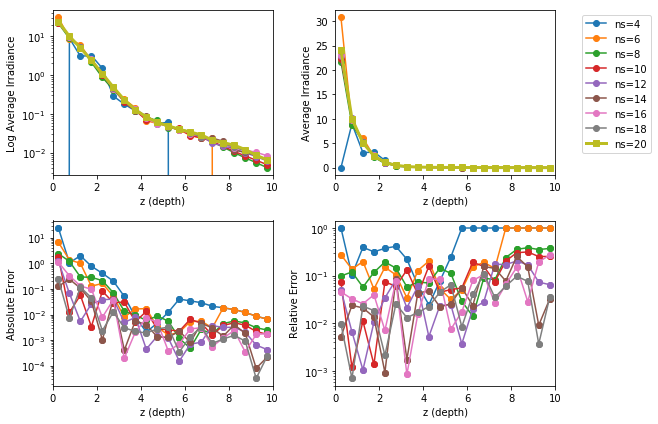

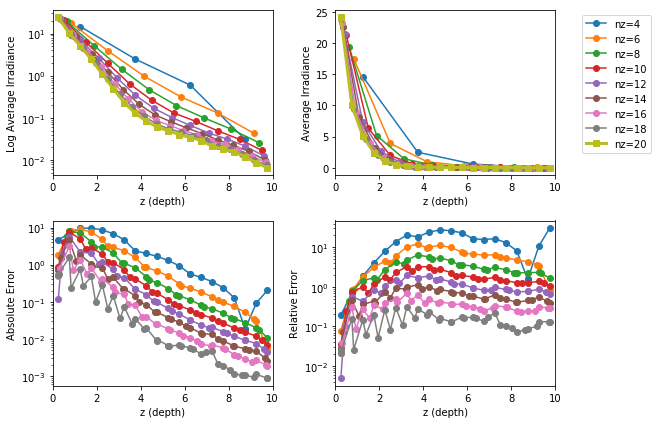

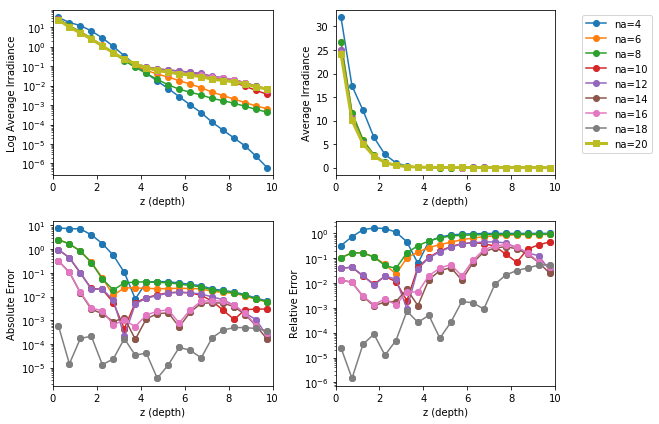

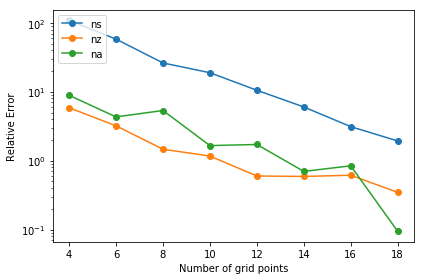

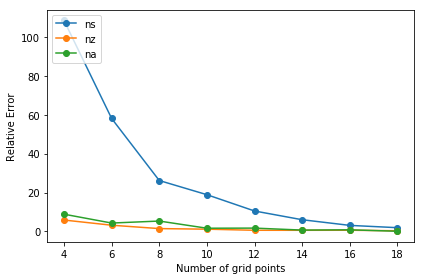

In [120]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

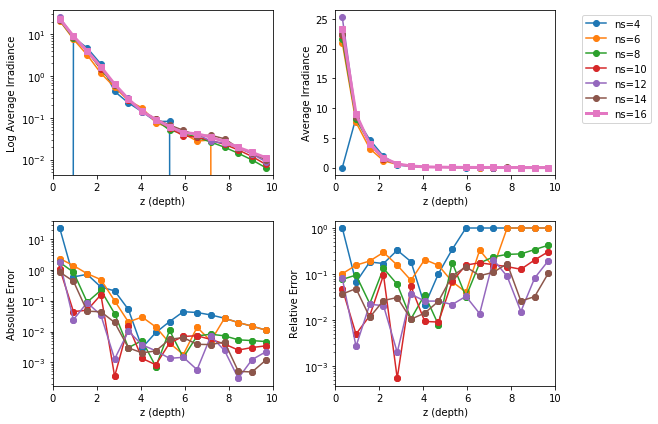

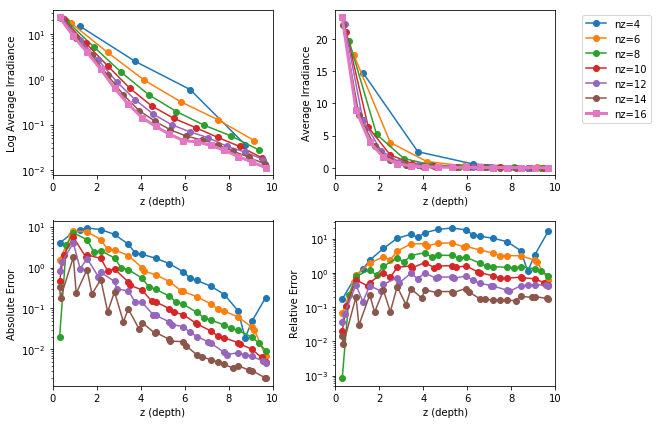

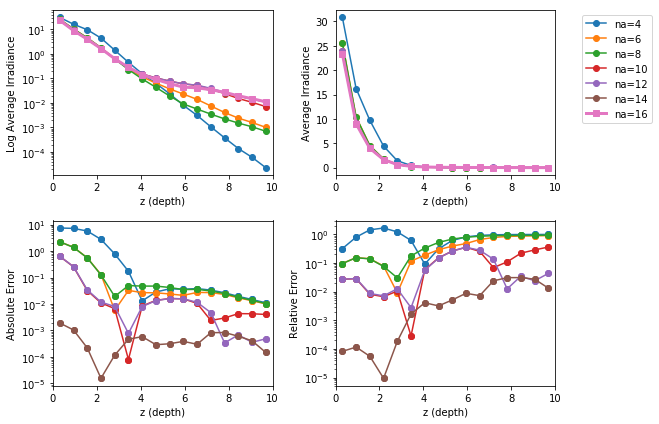

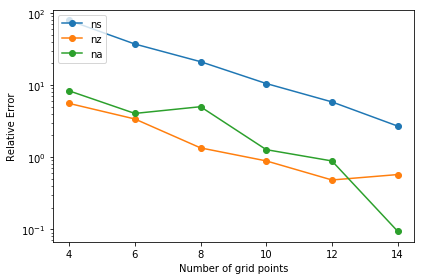

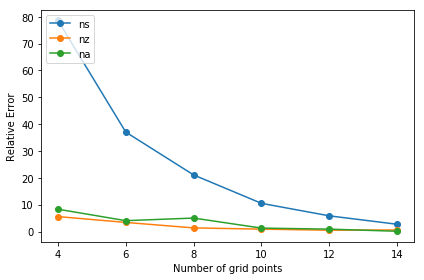

In [99]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

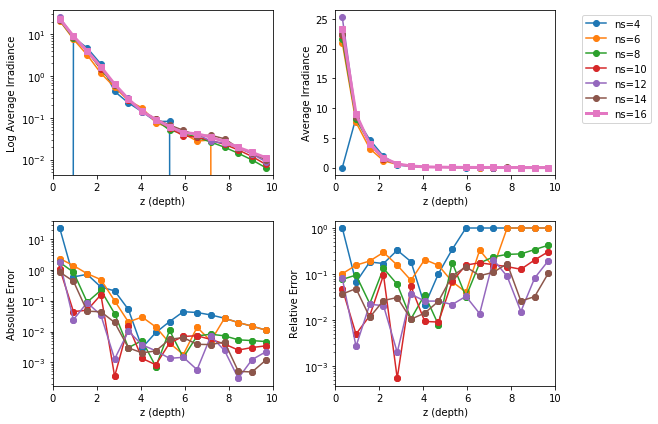

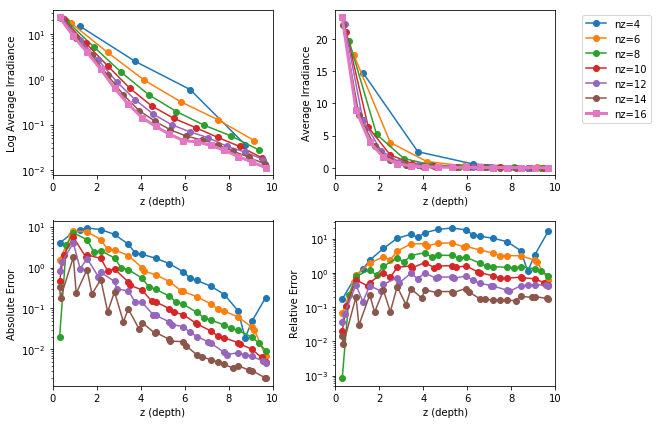

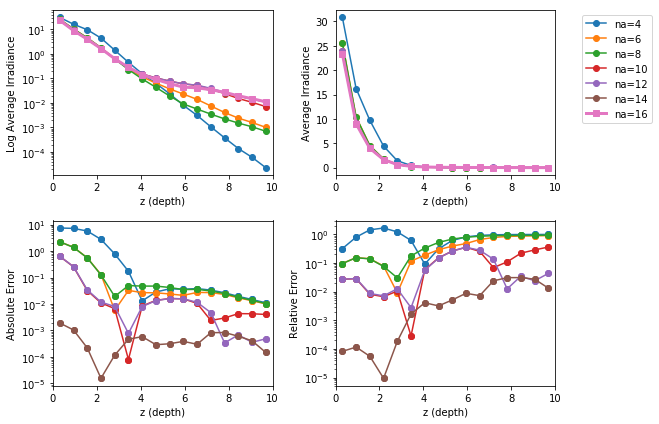

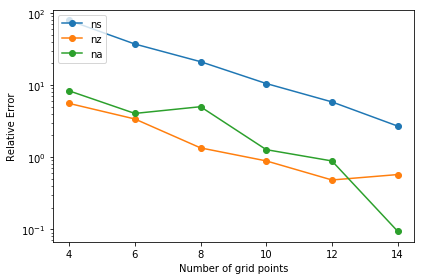

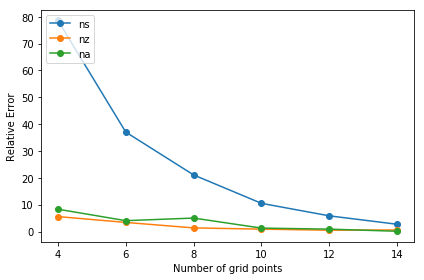

In [99]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

# Grid Study 2

In [ ]:
# Set parameters
a_water = 0.5
b = 0.05
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 16
nz_max = 16
na_max = 36
na_list = range(4,na_max+1,4)

irrad_dict, abs_err_arr, rel_err_arr = grid_study_compute(a_water, absorptance_kelp, kelp_profile, ns_max, nz_max, na_list)

In [104]:
# Set parameters
a_water = 0.5
b = 0.05
absorptance_kelp = 0.8
kelp_profile='top-heavy'
ns_max = 20
nz_max = 20
na_max = 20
ns_list = range(4, ns_max+1, 2)
nz_list = range(4, nz_max+1, 2)
na_list = range(4, na_max+1, 2)

ex = cf.ThreadPoolExecutor()
gs2_fut = ex.submit(
    grid_study_compute,
    a_water, absorptance_kelp, kelp_profile, ns_list, nz_list, na_list
)

ns_max = 20
nz_max = 20
na_max = 20


In [105]:
#perceived_irrad_dict, abs_err_arr, rel_err_arr = gs2_fut.result()

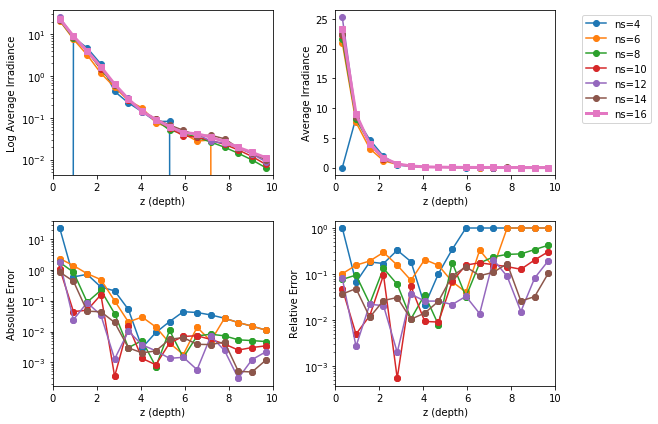

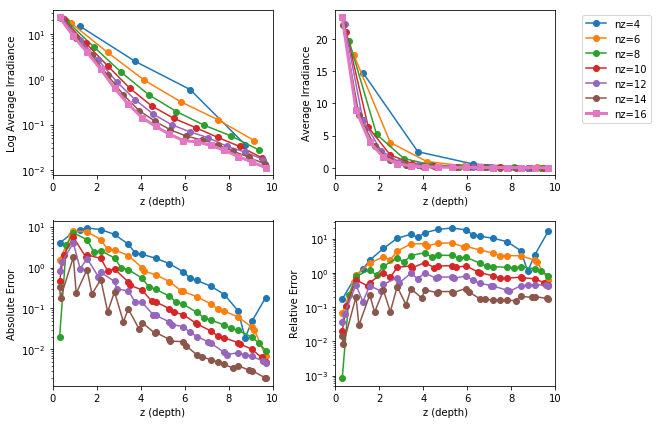

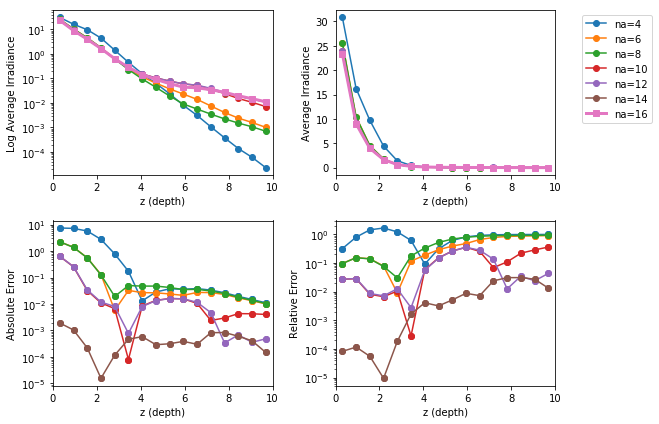

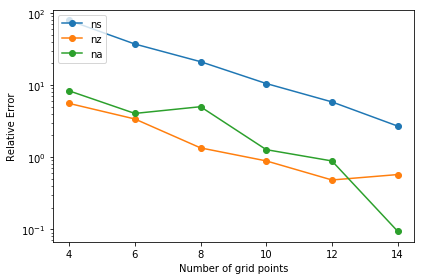

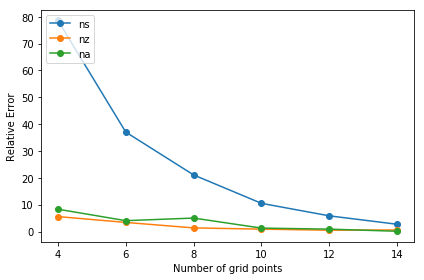

In [99]:
grid_study_plot(ns_list, nz_list, na_list, perceived_irrad_dict, abs_err_arr, rel_err_arr)

# Asymptotics Accuracy

In [187]:
# Set parameters
aut8 = [0.144, 0.037]
hao11 = [0.179, 0.219]
nuc2240 = [0.125, 1.205]
petzold_iops = [aut8, hao11, nuc2240]
petzold_names = ['aut8', 'hao11', 'nuc2240']

ns = 16
na = 16
nz = 16
kelp_profile='top-heavy'
max_scatter = 10

asym_conv_true_pi = {}

for name, (a_water, b) in zip(petzold_names, petzold_iops):
    # GMRES
    gmres_results = lv.apply(kelp_param.kelp_calculate,
        a_water,
        b,
        ns,
        na,
        nz,
        kelp_profile,
        absorptance_kelp=0.8,
        gmres_flag=True,
        num_scatters=0,
        const=const
    ).result()

    p_kelp = gmres_results['p_kelp']
    true_irrad = gmres_results['irradiance']
    true_rad = gmres_results['radiance']
    true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    asym_conv_true_pi[name] = true_perceived_irrad

In [189]:
save_dict = {}
res_dict = {}

scat_nums = range(0, max_scatter+1, 2)
# Run scattering cases
for name, (a_water, b) in zip(petzold_names, petzold_iops):
    res_list = []
    save_list = []
    true_perceived_irrad = asym_conv_true_pi[name]
    for n in scat_nums:
        print("n={}".format(n))
        #print("const={}".format(const))
        compute_results = lv.apply(kelp_param.kelp_calculate,
            a_water,
            b,
            ns,
            na,
            nz,
            kelp_profile,
            absorptance_kelp=0.8,
            gmres_flag=False,
            num_scatters=n,
            const=const
        ).result()

        irrad = compute_results['p_kelp']
        irrad = compute_results['irradiance']
        # Perceived irradiance for each depth layer
        perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
        perc_abs_err = np.abs(true_perceived_irrad - perceived_irrad)
        perc_rel_err = np.abs((true_perceived_irrad - perceived_irrad)/true_perceived_irrad)

        save_vals = {
            'rad_abs_err': rad_err,
            'rad_rel_err': rad_err / np.abs(gmres_results['radiance']),
            'irrad': irrad.mean(axis=(0,1)),
            'perceived_irrad': perceived_irrad,
            'perc_abs_err': perc_abs_err,
            'perc_rel_err': perc_rel_err
        }

        res_list.append(compute_results)
        save_list.append(save_vals)
    res_dict[name] = res_list
    save_dict[name] = save_list

n=0
n=2
n=4
n=6
n=8
n=10
n=0
n=2
n=4
n=6
n=8
n=10
n=0
n=2
n=4
n=6
n=8
n=10


### Plot Convergence Curves

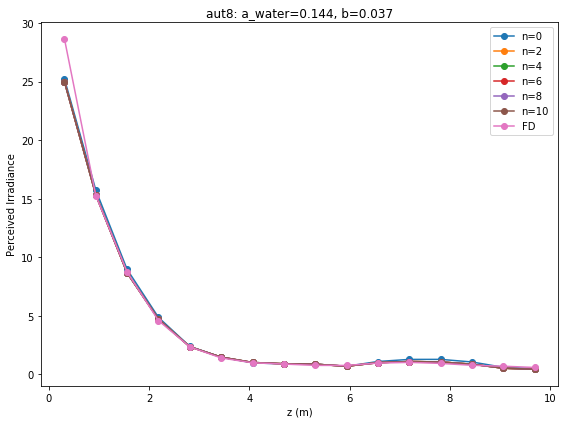

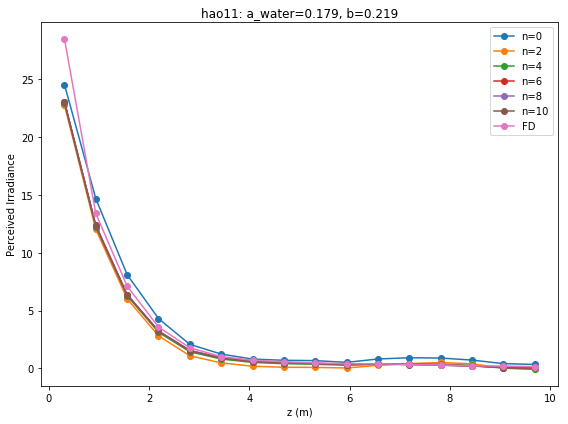

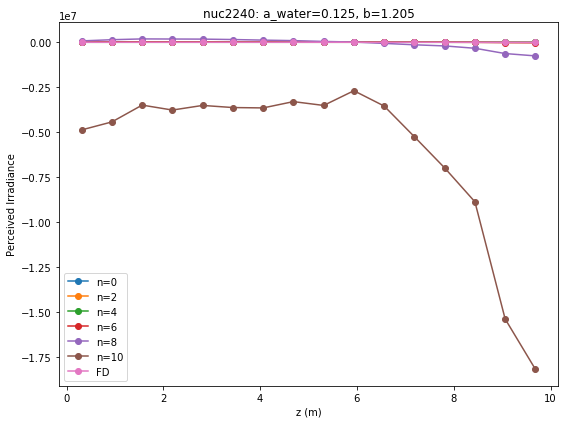

In [195]:
for name, iops in zip(petzold_names, petzold_iops):
    true_perceived_irrad = asym_conv_true_pi[name]
    plt.figure(figsize=[8,6])
    for i, scat in enumerate(res_dict[name]):
        plt.plot(z, save_dict[name][i]['perceived_irrad'], 'o-', label='n={}'.format(scat_nums[i]))
    
    plt.plot(z, true_perceived_irrad, 'o-', label='FD')
    plt.title("{}: a_water={}, b={}".format(name, *iops))
    plt.xlabel('z (m)')
    plt.ylabel('Perceived Irradiance')
    plt.yscale('linear')
    plt.legend()
    plt.tight_layout()
    
plt.show()

In [200]:
save_list['aut8'][0]

TypeError: list indices must be integers or slices, not str

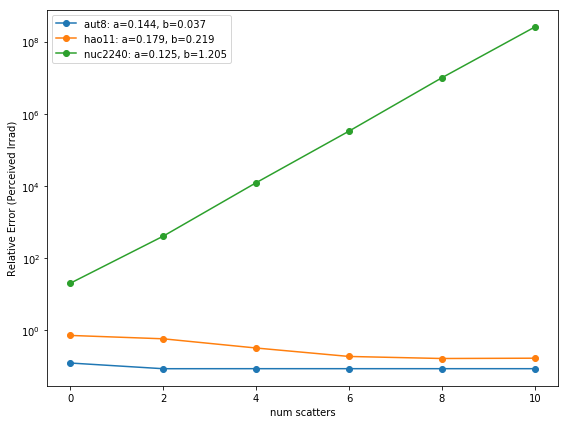

In [204]:
plt.figure(figsize=[8,6])
for name, iops in zip(petzold_names, petzold_iops):
    abs_err = np.array([res['perc_abs_err'].mean() for res in save_dict[name]])
    rel_err = np.array([res['perc_rel_err'].mean() for res in save_dict[name]])
    
    plt.plot(scat_nums, rel_err, 'o-', label='{}: a={}, b={}'.format(name, *iops))
    plt.xlabel('num scatters')
    plt.ylabel('Relative Error (Perceived Irrad)')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    
plt.show()

In [176]:
plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    print("n={}: a_eff={:.2f}, I0={:.2f}".format(n, a_eff, c))
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    #plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.yscale('log')
plt.xlim(zmin, zmax)
plt.ylim(1e-2, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    #plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.yscale('linear')
plt.xlim(zmin, zmax)
plt.ylim(0, I0)
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
for n, err in enumerate([s['irrad_abs_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Absolute Error')

plt.figure()
for n, err in enumerate([s['irrad_rel_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(scat_nums, [save_vals['irrad_abs_err'].mean() for save_vals in save_list], 'C0o-')
ax1.set_xlabel("Number of scatters")
ax1.set_ylabel("Absolute Error")
ax1.set_yscale('log')
ax2.plot(scat_nums, [save_vals['irrad_rel_err'].mean() for save_vals in save_list], 'C1o-')
ax2.set_ylabel('Relative Error')
ax2.set_yscale('log')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (16,) and (12,)

# Sensitivity Analysis